In [16]:
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5")
# pipeline.enable_model_cpu_offload()
num_inference_steps = 50



print(pipeline._callback_tensor_inputs)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

['latents', 'prompt_embeds', 'negative_prompt_embeds']


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


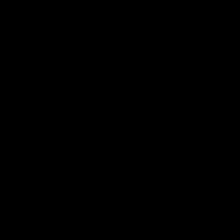

In [17]:
import torch
from PIL import Image

def interrupt_callback(pipeline, i, t, callback_kwargs):
    stop_idx = 10
    if i >= stop_idx:
        latents = callback_kwargs["latents"]
        latents[:, :, 0:8, 56:64] = 0
        callback_kwargs["latents"]=latents
        # print(latents.shape)


    return callback_kwargs

def latents_to_rgb(latents):
    weights = (
        (60, -60, 25, -70),
        (60,  -5, 15, -50),
        (60,  10, -5, -35),
    )

    weights_tensor = torch.t(torch.tensor(weights, dtype=latents.dtype).to(latents.device))
    biases_tensor = torch.tensor((150, 140, 130), dtype=latents.dtype).to(latents.device)
    rgb_tensor = torch.einsum("...lxy,lr -> ...rxy", latents, weights_tensor) + biases_tensor.unsqueeze(-1).unsqueeze(-1)
    image_array = rgb_tensor.clamp(0, 255).byte().cpu().numpy().transpose(1, 2, 0)

    return Image.fromarray(image_array)

def decode_tensors(pipe, step, timestep, callback_kwargs):
    latents = callback_kwargs["latents"]

    image = latents_to_rgb(latents[0])
    image.save(f"{step}.png")

    return callback_kwargs


out=pipeline(
    "A photo of a cat",
    height=224,
    width=224,
    num_inference_steps=num_inference_steps,
    callback_on_step_end=decode_tensors,
    callback_on_step_end_tensor_inputs=["latents"],
)
out.images[0]

(512, 512)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

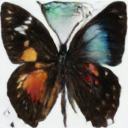

In [12]:
from diffusers import DiffusionPipeline

generator = DiffusionPipeline.from_pretrained("anton-l/ddpm-butterflies-128").to("cuda")
# print(generator._callback_tensor_inputs)
image = generator().images[0]
image

# 自行修改diffusion过程